In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [3]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [4]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [5]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [6]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  #plt.plot(epochs_range,mae,label='Training MAE')
  #plt.plot(epochs_range,val_mae,label='Validation MAE')
  #plt.plot(epochs_range,rmse,label='Training RMSE')
  #plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [7]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [8]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0:2])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [9]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [10]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, input_shape=(timesteps, features)))
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dense(2, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [11]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [12]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [13]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0],yhat[0][1]]],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [14]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [15]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}
# record da history de cada modelo
record = {}

In [16]:
n_variate = 2

Epoch 1/10
51/51 [==============================] - 3s 22ms/step - loss: 0.1874 - mae: 0.1824 - rmse: 0.1874 - val_loss: 0.0129 - val_mae: 0.0105 - val_rmse: 0.0125
Epoch 2/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0801 - mae: 0.0739 - rmse: 0.0801 - val_loss: 0.0178 - val_mae: 0.0146 - val_rmse: 0.0174
Epoch 3/10
51/51 [==============================] - 0s 6ms/step - loss: 0.0891 - mae: 0.0815 - rmse: 0.0891 - val_loss: 0.0248 - val_mae: 0.0205 - val_rmse: 0.0244
Epoch 4/10
51/51 [==============================] - 0s 6ms/step - loss: 0.1255 - mae: 0.1157 - rmse: 0.1255 - val_loss: 0.0516 - val_mae: 0.0399 - val_rmse: 0.0520
Epoch 5/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0797 - mae: 0.0693 - rmse: 0.0797 - val_loss: 0.0396 - val_mae: 0.0302 - val_rmse: 0.0400

Epoch 00005: val_loss improved from inf to 0.03957, saving model to my_model_5_0.040.h5
Epoch 6/10
51/51 [==============================] - 0s 5ms/step - loss: 0.0983 - mae: 0.09

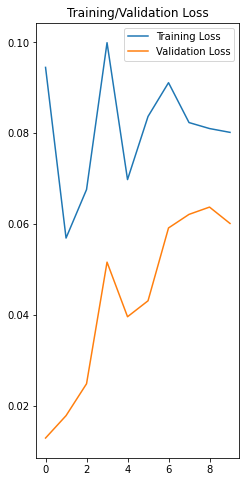

Epoch 1/10
102/102 [==============================] - 1s 6ms/step - loss: 0.0656 - mae: 0.0618 - rmse: 0.0655 - val_loss: 0.0243 - val_mae: 0.0217 - val_rmse: 0.0243
Epoch 2/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0872 - mae: 0.0841 - rmse: 0.0869 - val_loss: 0.0265 - val_mae: 0.0238 - val_rmse: 0.0264
Epoch 3/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0703 - mae: 0.0661 - rmse: 0.0700 - val_loss: 0.0244 - val_mae: 0.0217 - val_rmse: 0.0242
Epoch 4/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0657 - mae: 0.0613 - rmse: 0.0655 - val_loss: 0.0237 - val_mae: 0.0209 - val_rmse: 0.0233
Epoch 5/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0626 - mae: 0.0582 - rmse: 0.0624 - val_loss: 0.0236 - val_mae: 0.0209 - val_rmse: 0.0232

Epoch 00005: val_loss improved from 0.03957 to 0.02364, saving model to my_model_5_0.024.h5
Epoch 6/10
102/102 [==============================] - 1s 5ms/step - loss: 0.0

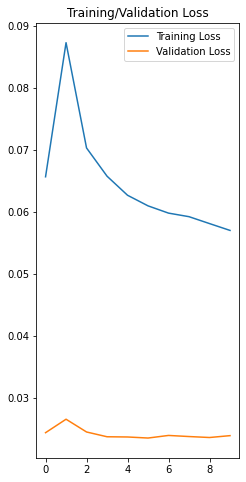

Epoch 1/10
152/152 [==============================] - 2s 5ms/step - loss: 0.0446 - mae: 0.0408 - rmse: 0.0446 - val_loss: 0.0621 - val_mae: 0.0505 - val_rmse: 0.0627
Epoch 2/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0348 - mae: 0.0306 - rmse: 0.0348 - val_loss: 0.0622 - val_mae: 0.0500 - val_rmse: 0.0627
Epoch 3/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0277 - mae: 0.0237 - rmse: 0.0277 - val_loss: 0.0598 - val_mae: 0.0482 - val_rmse: 0.0606
Epoch 4/10
152/152 [==============================] - 1s 5ms/step - loss: 0.0324 - mae: 0.0281 - rmse: 0.0324 - val_loss: 0.0624 - val_mae: 0.0502 - val_rmse: 0.0629
Epoch 5/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0281 - mae: 0.0239 - rmse: 0.0281 - val_loss: 0.0599 - val_mae: 0.0481 - val_rmse: 0.0606

Epoch 00005: val_loss did not improve from 0.02364
Epoch 6/10
152/152 [==============================] - 1s 4ms/step - loss: 0.0344 - mae: 0.0301 - rmse: 0.0344 - val_lo

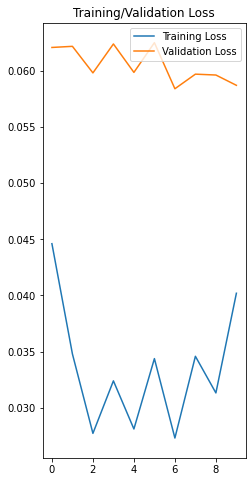

[array([[2476.0051, 2469.7075]], dtype=float32), array([[2470.571, 2462.613]], dtype=float32), array([[2466.5393, 2457.7432]], dtype=float32), array([[2462.8572, 2453.631 ]], dtype=float32), array([[2458.7803, 2449.3108]], dtype=float32), array([[2454.257 , 2444.5693]], dtype=float32), array([[2449.5254, 2439.5771]], dtype=float32), array([[2444.621 , 2434.3892]], dtype=float32), array([[2439.7805, 2429.2305]], dtype=float32), array([[2434.928 , 2424.0618]], dtype=float32), array([[2430.0425, 2418.8625]], dtype=float32), array([[2425.1125, 2413.6184]], dtype=float32), array([[2420.1384, 2408.3281]], dtype=float32), array([[2415.1267, 2402.9966]], dtype=float32), array([[2410.0837, 2397.6306]], dtype=float32)]
[2476.0051, 2470.571, 2466.5393, 2462.8572, 2458.7803, 2454.257, 2449.5254, 2444.621, 2439.7805, 2434.928, 2430.0425, 2425.1125, 2420.1384, 2415.1267, 2410.0837]


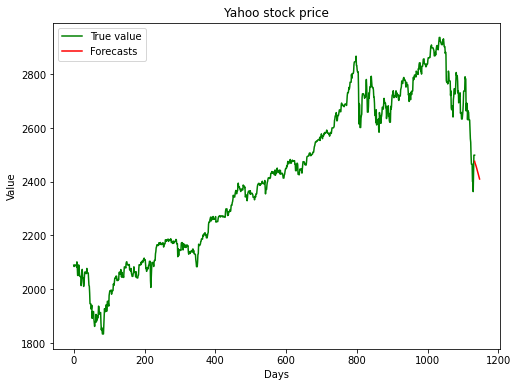

Epoch 1/50
51/51 [==============================] - 2s 15ms/step - loss: 0.1870 - mae: 0.1825 - rmse: 0.1870 - val_loss: 0.0137 - val_mae: 0.0113 - val_rmse: 0.0134
Epoch 2/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0840 - mae: 0.0783 - rmse: 0.0840 - val_loss: 0.0183 - val_mae: 0.0151 - val_rmse: 0.0178
Epoch 3/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0955 - mae: 0.0900 - rmse: 0.0955 - val_loss: 0.0262 - val_mae: 0.0237 - val_rmse: 0.0257
Epoch 4/50
51/51 [==============================] - 0s 6ms/step - loss: 0.1400 - mae: 0.1351 - rmse: 0.1400 - val_loss: 0.0647 - val_mae: 0.0639 - val_rmse: 0.0651
Epoch 5/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0781 - mae: 0.0706 - rmse: 0.0781 - val_loss: 0.0622 - val_mae: 0.0614 - val_rmse: 0.0627

Epoch 00005: val_loss improved from inf to 0.06221, saving model to my_model_5_0.062.h5
Epoch 6/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0864 - mae: 0.07

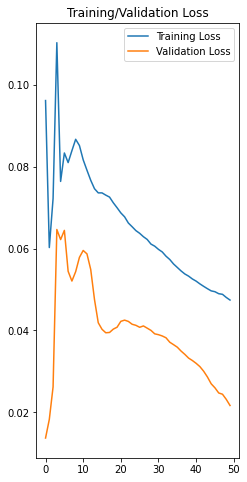

Epoch 1/50
102/102 [==============================] - 1s 6ms/step - loss: 0.0362 - mae: 0.0311 - rmse: 0.0361 - val_loss: 0.0274 - val_mae: 0.0236 - val_rmse: 0.0268
Epoch 2/50
102/102 [==============================] - 1s 6ms/step - loss: 0.0405 - mae: 0.0348 - rmse: 0.0403 - val_loss: 0.0311 - val_mae: 0.0270 - val_rmse: 0.0305
Epoch 3/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0384 - mae: 0.0326 - rmse: 0.0382 - val_loss: 0.0350 - val_mae: 0.0309 - val_rmse: 0.0345
Epoch 4/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0451 - mae: 0.0386 - rmse: 0.0448 - val_loss: 0.0331 - val_mae: 0.0299 - val_rmse: 0.0324
Epoch 5/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0434 - mae: 0.0378 - rmse: 0.0432 - val_loss: 0.0314 - val_mae: 0.0284 - val_rmse: 0.0305

Epoch 00005: val_loss did not improve from 0.02166
Epoch 6/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0492 - mae: 0.0447 - rmse: 0.0490 - val_lo

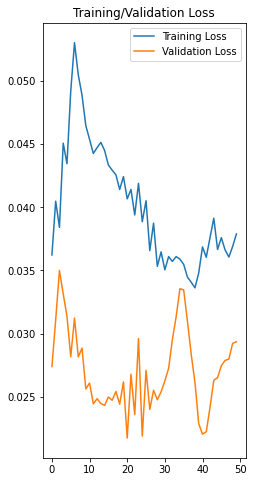

Epoch 1/50
152/152 [==============================] - 2s 5ms/step - loss: 0.0305 - mae: 0.0259 - rmse: 0.0305 - val_loss: 0.0751 - val_mae: 0.0653 - val_rmse: 0.0752
Epoch 2/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0275 - mae: 0.0229 - rmse: 0.0275 - val_loss: 0.0753 - val_mae: 0.0658 - val_rmse: 0.0755
Epoch 3/50
152/152 [==============================] - 1s 4ms/step - loss: 0.0262 - mae: 0.0217 - rmse: 0.0262 - val_loss: 0.0627 - val_mae: 0.0524 - val_rmse: 0.0631
Epoch 4/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0262 - mae: 0.0217 - rmse: 0.0262 - val_loss: 0.0699 - val_mae: 0.0601 - val_rmse: 0.0701
Epoch 5/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0260 - mae: 0.0215 - rmse: 0.0260 - val_loss: 0.0680 - val_mae: 0.0580 - val_rmse: 0.0683

Epoch 00005: val_loss did not improve from 0.02166
Epoch 6/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0262 - mae: 0.0216 - rmse: 0.0262 - val_lo

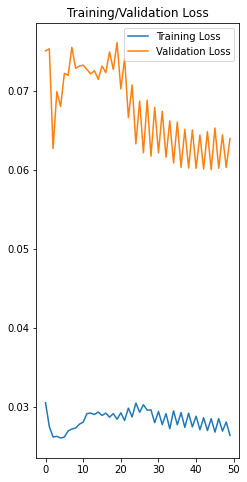

[array([[2482.603 , 2491.8093]], dtype=float32), array([[2486.3486, 2494.7256]], dtype=float32), array([[2490.615 , 2498.5686]], dtype=float32), array([[2494.7737, 2502.5645]], dtype=float32), array([[2498.6895, 2506.551 ]], dtype=float32), array([[2502.517, 2510.506]], dtype=float32), array([[2506.4817, 2514.5388]], dtype=float32), array([[2510.6199, 2518.7192]], dtype=float32), array([[2514.957 , 2523.0725]], dtype=float32), array([[2519.447 , 2527.5854]], dtype=float32), array([[2524.0774, 2532.2412]], dtype=float32), array([[2528.8433, 2537.0308]], dtype=float32), array([[2533.7402, 2541.9482]], dtype=float32), array([[2538.7632, 2546.9866]], dtype=float32), array([[2543.9038, 2552.137 ]], dtype=float32)]
[2482.603, 2486.3486, 2490.615, 2494.7737, 2498.6895, 2502.517, 2506.4817, 2510.6199, 2514.957, 2519.447, 2524.0774, 2528.8433, 2533.7402, 2538.7632, 2543.9038]


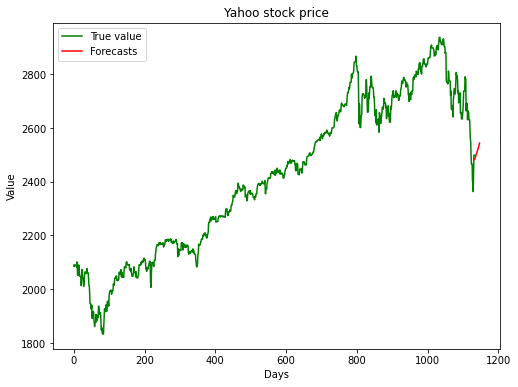

Epoch 1/100
51/51 [==============================] - 2s 15ms/step - loss: 0.1915 - mae: 0.1856 - rmse: 0.1914 - val_loss: 0.0130 - val_mae: 0.0112 - val_rmse: 0.0125
Epoch 2/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0857 - mae: 0.0783 - rmse: 0.0857 - val_loss: 0.0213 - val_mae: 0.0190 - val_rmse: 0.0210
Epoch 3/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0879 - mae: 0.0770 - rmse: 0.0879 - val_loss: 0.0196 - val_mae: 0.0164 - val_rmse: 0.0191
Epoch 4/100
51/51 [==============================] - 0s 6ms/step - loss: 0.1287 - mae: 0.1147 - rmse: 0.1287 - val_loss: 0.0353 - val_mae: 0.0270 - val_rmse: 0.0357
Epoch 5/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0852 - mae: 0.0737 - rmse: 0.0852 - val_loss: 0.0377 - val_mae: 0.0289 - val_rmse: 0.0381

Epoch 00005: val_loss improved from inf to 0.03772, saving model to my_model_5_0.038.h5
Epoch 6/100
51/51 [==============================] - 0s 6ms/step - loss: 0.0941 - mae

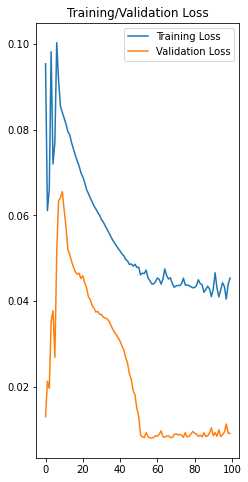

Epoch 1/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0316 - mae: 0.0263 - rmse: 0.0314 - val_loss: 0.0228 - val_mae: 0.0195 - val_rmse: 0.0219
Epoch 2/100
102/102 [==============================] - 1s 5ms/step - loss: 0.0367 - mae: 0.0319 - rmse: 0.0365 - val_loss: 0.0249 - val_mae: 0.0218 - val_rmse: 0.0237
Epoch 3/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0373 - mae: 0.0327 - rmse: 0.0371 - val_loss: 0.0273 - val_mae: 0.0244 - val_rmse: 0.0262
Epoch 4/100
102/102 [==============================] - 1s 6ms/step - loss: 0.0461 - mae: 0.0418 - rmse: 0.0459 - val_loss: 0.0213 - val_mae: 0.0177 - val_rmse: 0.0205
Epoch 5/100
102/102 [==============================] - 1s 5ms/step - loss: 0.0389 - mae: 0.0344 - rmse: 0.0387 - val_loss: 0.0249 - val_mae: 0.0204 - val_rmse: 0.0245

Epoch 00005: val_loss did not improve from 0.00817
Epoch 6/100
102/102 [==============================] - 1s 5ms/step - loss: 0.0419 - mae: 0.0372 - rmse: 0.0417 - 

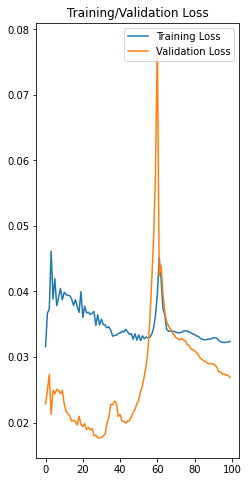

Epoch 1/100
152/152 [==============================] - 2s 5ms/step - loss: 0.0289 - mae: 0.0243 - rmse: 0.0289 - val_loss: 0.0695 - val_mae: 0.0597 - val_rmse: 0.0698
Epoch 2/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0252 - mae: 0.0206 - rmse: 0.0252 - val_loss: 0.0696 - val_mae: 0.0599 - val_rmse: 0.0699
Epoch 3/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0248 - mae: 0.0203 - rmse: 0.0248 - val_loss: 0.0728 - val_mae: 0.0634 - val_rmse: 0.0731
Epoch 4/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0264 - mae: 0.0220 - rmse: 0.0264 - val_loss: 0.0587 - val_mae: 0.0477 - val_rmse: 0.0593
Epoch 5/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0245 - mae: 0.0200 - rmse: 0.0245 - val_loss: 0.0654 - val_mae: 0.0552 - val_rmse: 0.0658

Epoch 00005: val_loss did not improve from 0.00817
Epoch 6/100
152/152 [==============================] - 1s 5ms/step - loss: 0.0257 - mae: 0.0213 - rmse: 0.0257 - 

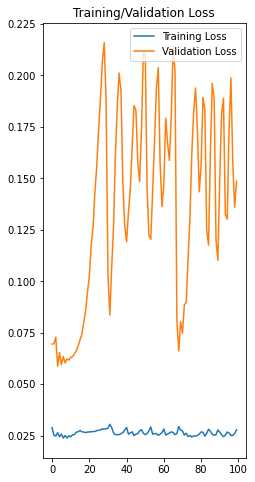

[array([[2500.6562, 2507.114 ]], dtype=float32), array([[2516.3767, 2524.271 ]], dtype=float32), array([[2531.5078, 2539.6245]], dtype=float32), array([[2547.0308, 2555.1353]], dtype=float32), array([[2562.2092, 2570.3872]], dtype=float32), array([[2577.074, 2585.257]], dtype=float32), array([[2592.0657, 2600.0994]], dtype=float32), array([[2607.133 , 2614.9604]], dtype=float32), array([[2622.096 , 2629.7012]], dtype=float32), array([[2636.79  , 2644.1545]], dtype=float32), array([[2651.0361, 2658.131 ]], dtype=float32), array([[2664.609 , 2671.4043]], dtype=float32), array([[2677.2366, 2683.698 ]], dtype=float32), array([[2688.5757, 2694.6653]], dtype=float32), array([[2698.2188, 2703.8967]], dtype=float32)]
[2500.6562, 2516.3767, 2531.5078, 2547.0308, 2562.2092, 2577.074, 2592.0657, 2607.133, 2622.096, 2636.79, 2651.0361, 2664.609, 2677.2366, 2688.5757, 2698.2188]


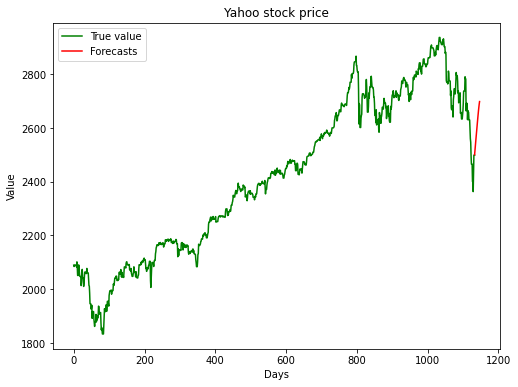

Epoch 1/60
51/51 [==============================] - 3s 15ms/step - loss: 0.2036 - mae: 0.1983 - rmse: 0.2036 - val_loss: 0.0208 - val_mae: 0.0191 - val_rmse: 0.0203
Epoch 2/60
51/51 [==============================] - 0s 7ms/step - loss: 0.0819 - mae: 0.0746 - rmse: 0.0819 - val_loss: 0.0192 - val_mae: 0.0156 - val_rmse: 0.0187
Epoch 3/60
51/51 [==============================] - 0s 7ms/step - loss: 0.1161 - mae: 0.1077 - rmse: 0.1161 - val_loss: 0.0085 - val_mae: 0.0068 - val_rmse: 0.0085
Epoch 4/60
51/51 [==============================] - 0s 7ms/step - loss: 0.1284 - mae: 0.1184 - rmse: 0.1283 - val_loss: 0.0463 - val_mae: 0.0364 - val_rmse: 0.0467
Epoch 5/60
51/51 [==============================] - 0s 7ms/step - loss: 0.0808 - mae: 0.0689 - rmse: 0.0808 - val_loss: 0.0411 - val_mae: 0.0335 - val_rmse: 0.0416

Epoch 00005: val_loss improved from inf to 0.04113, saving model to my_model_5_0.041.h5
Epoch 6/60
51/51 [==============================] - 0s 7ms/step - loss: 0.0904 - mae: 0.08

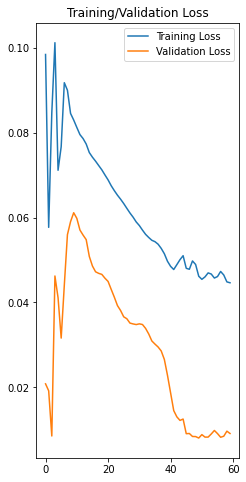

Epoch 1/60
102/102 [==============================] - 1s 7ms/step - loss: 0.0341 - mae: 0.0296 - rmse: 0.0339 - val_loss: 0.0222 - val_mae: 0.0187 - val_rmse: 0.0214
Epoch 2/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0400 - mae: 0.0358 - rmse: 0.0397 - val_loss: 0.0383 - val_mae: 0.0349 - val_rmse: 0.0378
Epoch 3/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0475 - mae: 0.0434 - rmse: 0.0473 - val_loss: 0.0280 - val_mae: 0.0250 - val_rmse: 0.0276
Epoch 4/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0548 - mae: 0.0490 - rmse: 0.0545 - val_loss: 0.0327 - val_mae: 0.0296 - val_rmse: 0.0321
Epoch 5/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0495 - mae: 0.0443 - rmse: 0.0493 - val_loss: 0.0309 - val_mae: 0.0279 - val_rmse: 0.0303

Epoch 00005: val_loss did not improve from 0.00803
Epoch 6/60
102/102 [==============================] - 1s 6ms/step - loss: 0.0511 - mae: 0.0467 - rmse: 0.0508 - val_lo

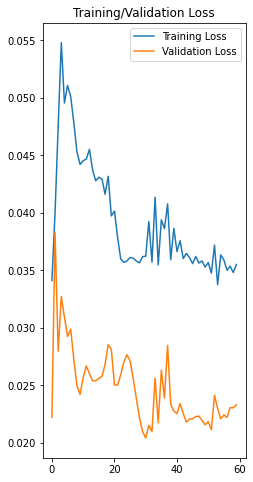

Epoch 1/60
152/152 [==============================] - 1s 7ms/step - loss: 0.0300 - mae: 0.0256 - rmse: 0.0299 - val_loss: 0.0685 - val_mae: 0.0584 - val_rmse: 0.0688
Epoch 2/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0265 - mae: 0.0220 - rmse: 0.0265 - val_loss: 0.0697 - val_mae: 0.0597 - val_rmse: 0.0700
Epoch 3/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0273 - mae: 0.0228 - rmse: 0.0273 - val_loss: 0.0580 - val_mae: 0.0469 - val_rmse: 0.0587
Epoch 4/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0266 - mae: 0.0221 - rmse: 0.0266 - val_loss: 0.0657 - val_mae: 0.0553 - val_rmse: 0.0661
Epoch 5/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0268 - mae: 0.0224 - rmse: 0.0268 - val_loss: 0.0583 - val_mae: 0.0473 - val_rmse: 0.0589

Epoch 00005: val_loss did not improve from 0.00803
Epoch 6/60
152/152 [==============================] - 1s 6ms/step - loss: 0.0263 - mae: 0.0217 - rmse: 0.0263 - val_lo

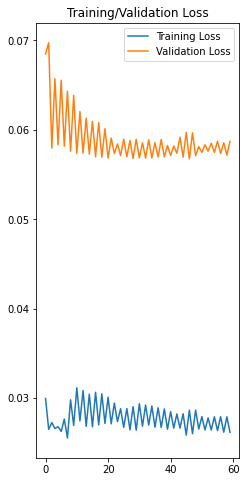

[array([[2488.639, 2497.75 ]], dtype=float32), array([[2496.5425, 2506.025 ]], dtype=float32), array([[2504.347 , 2513.6938]], dtype=float32), array([[2511.804 , 2520.9978]], dtype=float32), array([[2519.0222, 2528.164 ]], dtype=float32), array([[2526.2917, 2535.4385]], dtype=float32), array([[2533.7786, 2542.9456]], dtype=float32), array([[2541.4663, 2550.6362]], dtype=float32), array([[2549.2942, 2558.4465]], dtype=float32), array([[2557.186, 2566.307]], dtype=float32), array([[2565.112 , 2574.1873]], dtype=float32), array([[2573.041 , 2582.0552]], dtype=float32), array([[2580.9397, 2589.8755]], dtype=float32), array([[2588.77, 2597.61]], dtype=float32), array([[2596.4924, 2605.2188]], dtype=float32)]
[2488.639, 2496.5425, 2504.347, 2511.804, 2519.0222, 2526.2917, 2533.7786, 2541.4663, 2549.2942, 2557.186, 2565.112, 2573.041, 2580.9397, 2588.77, 2596.4924]


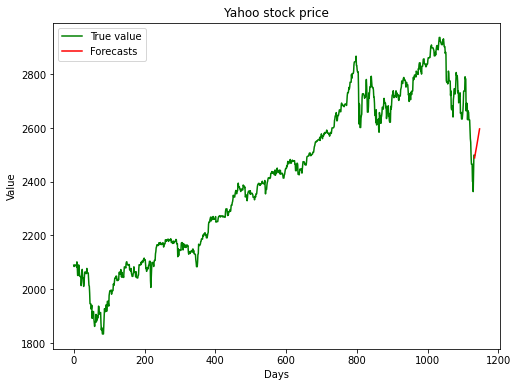

Epoch 1/90
51/51 [==============================] - 3s 16ms/step - loss: 0.2433 - mae: 0.2372 - rmse: 0.2433 - val_loss: 0.0164 - val_mae: 0.0140 - val_rmse: 0.0159
Epoch 2/90
51/51 [==============================] - 0s 6ms/step - loss: 0.0883 - mae: 0.0817 - rmse: 0.0883 - val_loss: 0.0255 - val_mae: 0.0207 - val_rmse: 0.0250
Epoch 3/90
51/51 [==============================] - 0s 7ms/step - loss: 0.1311 - mae: 0.1246 - rmse: 0.1311 - val_loss: 0.0694 - val_mae: 0.0655 - val_rmse: 0.0698
Epoch 4/90
51/51 [==============================] - 0s 7ms/step - loss: 0.0888 - mae: 0.0795 - rmse: 0.0888 - val_loss: 0.0674 - val_mae: 0.0627 - val_rmse: 0.0678
Epoch 5/90
51/51 [==============================] - 0s 7ms/step - loss: 0.0911 - mae: 0.0807 - rmse: 0.0911 - val_loss: 0.0592 - val_mae: 0.0555 - val_rmse: 0.0595

Epoch 00005: val_loss improved from inf to 0.05916, saving model to my_model_5_0.059.h5
Epoch 6/90
51/51 [==============================] - 0s 7ms/step - loss: 0.0966 - mae: 0.08

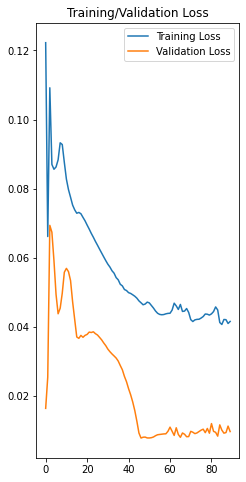

Epoch 1/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0321 - mae: 0.0272 - rmse: 0.0319 - val_loss: 0.0235 - val_mae: 0.0201 - val_rmse: 0.0234
Epoch 2/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0356 - mae: 0.0310 - rmse: 0.0353 - val_loss: 0.0224 - val_mae: 0.0184 - val_rmse: 0.0214
Epoch 3/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0358 - mae: 0.0314 - rmse: 0.0356 - val_loss: 0.0284 - val_mae: 0.0254 - val_rmse: 0.0272
Epoch 4/90
102/102 [==============================] - 1s 6ms/step - loss: 0.0442 - mae: 0.0400 - rmse: 0.0439 - val_loss: 0.0271 - val_mae: 0.0240 - val_rmse: 0.0260
Epoch 5/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0445 - mae: 0.0398 - rmse: 0.0442 - val_loss: 0.0229 - val_mae: 0.0193 - val_rmse: 0.0222

Epoch 00005: val_loss did not improve from 0.00787
Epoch 6/90
102/102 [==============================] - 1s 7ms/step - loss: 0.0377 - mae: 0.0325 - rmse: 0.0375 - val_lo

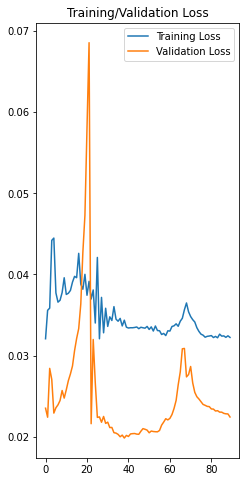

Epoch 1/90
152/152 [==============================] - 1s 7ms/step - loss: 0.0279 - mae: 0.0233 - rmse: 0.0279 - val_loss: 0.0823 - val_mae: 0.0730 - val_rmse: 0.0824
Epoch 2/90
152/152 [==============================] - 1s 7ms/step - loss: 0.0285 - mae: 0.0239 - rmse: 0.0285 - val_loss: 0.0615 - val_mae: 0.0507 - val_rmse: 0.0621
Epoch 3/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0250 - mae: 0.0204 - rmse: 0.0250 - val_loss: 0.0685 - val_mae: 0.0588 - val_rmse: 0.0689
Epoch 4/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0248 - mae: 0.0203 - rmse: 0.0248 - val_loss: 0.0641 - val_mae: 0.0541 - val_rmse: 0.0646
Epoch 5/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0253 - mae: 0.0207 - rmse: 0.0253 - val_loss: 0.0634 - val_mae: 0.0532 - val_rmse: 0.0639

Epoch 00005: val_loss did not improve from 0.00787
Epoch 6/90
152/152 [==============================] - 1s 6ms/step - loss: 0.0257 - mae: 0.0210 - rmse: 0.0257 - val_lo

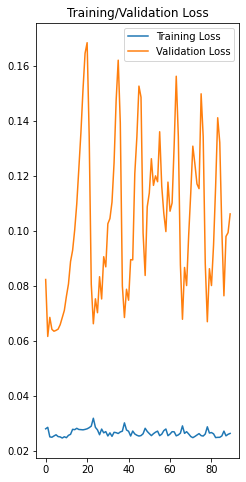

[array([[2499.7249, 2502.0532]], dtype=float32), array([[2513.852 , 2516.9666]], dtype=float32), array([[2528.8442, 2532.3413]], dtype=float32), array([[2543.6484, 2547.401 ]], dtype=float32), array([[2558.2227, 2562.2493]], dtype=float32), array([[2572.851, 2577.13 ]], dtype=float32), array([[2587.7852, 2592.2837]], dtype=float32), array([[2603.14  , 2607.8538]], dtype=float32), array([[2618.8213, 2623.7673]], dtype=float32), array([[2634.6106, 2639.8225]], dtype=float32), array([[2650.2502, 2655.7454]], dtype=float32), array([[2665.4365, 2671.2107]], dtype=float32), array([[2679.7876, 2685.8079]], dtype=float32), array([[2692.819, 2699.008]], dtype=float32), array([[2703.9495, 2710.172 ]], dtype=float32)]
[2499.7249, 2513.852, 2528.8442, 2543.6484, 2558.2227, 2572.851, 2587.7852, 2603.14, 2618.8213, 2634.6106, 2650.2502, 2665.4365, 2679.7876, 2692.819, 2703.9495]


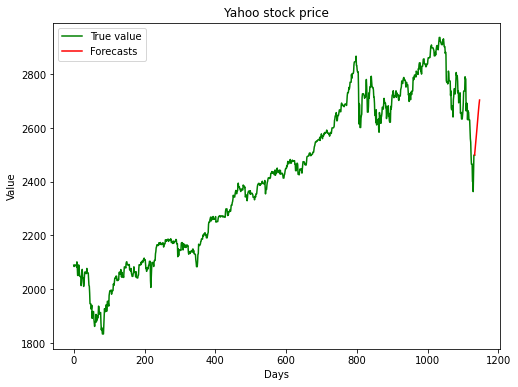

Epoch 1/120
51/51 [==============================] - 3s 17ms/step - loss: 0.2745 - mae: 0.2690 - rmse: 0.2744 - val_loss: 0.0176 - val_mae: 0.0157 - val_rmse: 0.0171
Epoch 2/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0931 - mae: 0.0874 - rmse: 0.0931 - val_loss: 0.0254 - val_mae: 0.0213 - val_rmse: 0.0250
Epoch 3/120
51/51 [==============================] - 0s 7ms/step - loss: 0.1390 - mae: 0.1323 - rmse: 0.1390 - val_loss: 0.0629 - val_mae: 0.0607 - val_rmse: 0.0634
Epoch 4/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0864 - mae: 0.0790 - rmse: 0.0864 - val_loss: 0.0655 - val_mae: 0.0619 - val_rmse: 0.0660
Epoch 5/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0857 - mae: 0.0769 - rmse: 0.0857 - val_loss: 0.0543 - val_mae: 0.0497 - val_rmse: 0.0547

Epoch 00005: val_loss improved from inf to 0.05425, saving model to my_model_5_0.054.h5
Epoch 6/120
51/51 [==============================] - 0s 7ms/step - loss: 0.0889 - mae

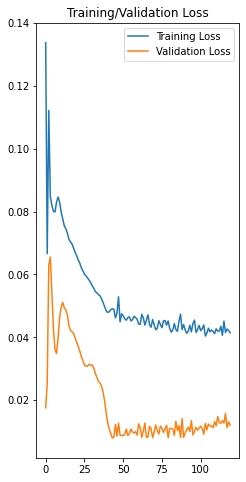

Epoch 1/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0330 - mae: 0.0279 - rmse: 0.0328 - val_loss: 0.0280 - val_mae: 0.0236 - val_rmse: 0.0296
Epoch 2/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0342 - mae: 0.0294 - rmse: 0.0340 - val_loss: 0.0261 - val_mae: 0.0223 - val_rmse: 0.0276
Epoch 3/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0342 - mae: 0.0295 - rmse: 0.0340 - val_loss: 0.0287 - val_mae: 0.0247 - val_rmse: 0.0306
Epoch 4/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0343 - mae: 0.0294 - rmse: 0.0341 - val_loss: 0.0279 - val_mae: 0.0235 - val_rmse: 0.0298
Epoch 5/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0329 - mae: 0.0278 - rmse: 0.0328 - val_loss: 0.0238 - val_mae: 0.0195 - val_rmse: 0.0254

Epoch 00005: val_loss did not improve from 0.00805
Epoch 6/120
102/102 [==============================] - 1s 7ms/step - loss: 0.0327 - mae: 0.0275 - rmse: 0.0325 - 

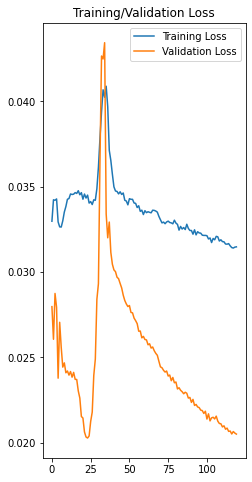

Epoch 1/120
152/152 [==============================] - 1s 7ms/step - loss: 0.0273 - mae: 0.0226 - rmse: 0.0272 - val_loss: 0.0625 - val_mae: 0.0506 - val_rmse: 0.0629
Epoch 2/120
152/152 [==============================] - 1s 7ms/step - loss: 0.0250 - mae: 0.0204 - rmse: 0.0250 - val_loss: 0.0646 - val_mae: 0.0538 - val_rmse: 0.0650
Epoch 3/120
152/152 [==============================] - 1s 7ms/step - loss: 0.0270 - mae: 0.0225 - rmse: 0.0271 - val_loss: 0.0567 - val_mae: 0.0451 - val_rmse: 0.0574
Epoch 4/120
152/152 [==============================] - 1s 7ms/step - loss: 0.0242 - mae: 0.0198 - rmse: 0.0242 - val_loss: 0.0593 - val_mae: 0.0483 - val_rmse: 0.0597
Epoch 5/120
152/152 [==============================] - 1s 7ms/step - loss: 0.0258 - mae: 0.0214 - rmse: 0.0258 - val_loss: 0.0565 - val_mae: 0.0450 - val_rmse: 0.0571

Epoch 00005: val_loss did not improve from 0.00805
Epoch 6/120
152/152 [==============================] - 1s 7ms/step - loss: 0.0247 - mae: 0.0203 - rmse: 0.0247 - 

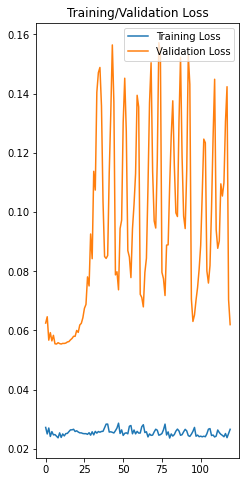

[array([[2487.5164, 2494.5364]], dtype=float32), array([[2493.5342, 2501.07  ]], dtype=float32), array([[2500.699 , 2508.6353]], dtype=float32), array([[2508.3337, 2516.5332]], dtype=float32), array([[2516.0435, 2524.867 ]], dtype=float32), array([[2523.5142, 2532.705 ]], dtype=float32), array([[2530.6887, 2539.953 ]], dtype=float32), array([[2537.7703, 2547.012 ]], dtype=float32), array([[2544.8386, 2554.008 ]], dtype=float32), array([[2551.962 , 2561.0947]], dtype=float32), array([[2559.1033, 2568.1995]], dtype=float32), array([[2566.2605, 2575.319 ]], dtype=float32), array([[2573.4329, 2582.45  ]], dtype=float32), array([[2580.6284, 2589.6018]], dtype=float32), array([[2587.8499, 2596.776 ]], dtype=float32)]
[2487.5164, 2493.5342, 2500.699, 2508.3337, 2516.0435, 2523.5142, 2530.6887, 2537.7703, 2544.8386, 2551.962, 2559.1033, 2566.2605, 2573.4329, 2580.6284, 2587.8499]


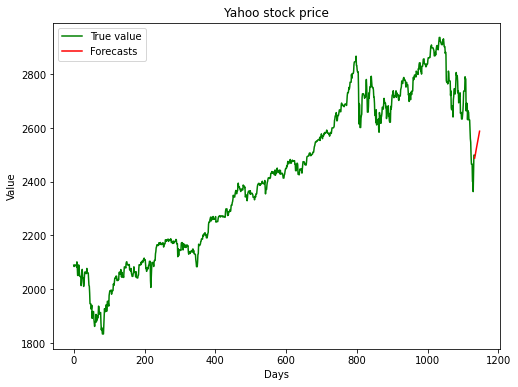

Epoch 1/50
32/32 [==============================] - 3s 25ms/step - loss: 0.2972 - mae: 0.2893 - rmse: 0.2971 - val_loss: 0.0251 - val_mae: 0.0192 - val_rmse: 0.0268
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0838 - mae: 0.0728 - rmse: 0.0838 - val_loss: 0.0271 - val_mae: 0.0213 - val_rmse: 0.0286
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0932 - mae: 0.0834 - rmse: 0.0932 - val_loss: 0.0207 - val_mae: 0.0151 - val_rmse: 0.0232
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.1015 - mae: 0.0924 - rmse: 0.1015 - val_loss: 0.0187 - val_mae: 0.0140 - val_rmse: 0.0220
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0927 - mae: 0.0846 - rmse: 0.0927 - val_loss: 0.0188 - val_mae: 0.0137 - val_rmse: 0.0223

Epoch 00005: val_loss improved from inf to 0.01879, saving model to my_model_5_0.019.h5
Epoch 6/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0910 - mae: 0.08

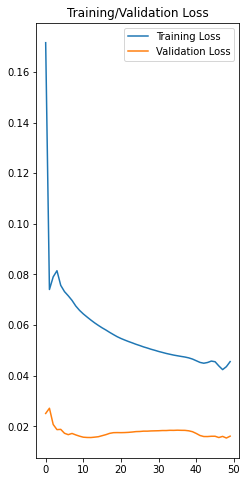

Epoch 1/50
64/64 [==============================] - 1s 15ms/step - loss: 0.0346 - mae: 0.0285 - rmse: 0.0344 - val_loss: 0.0204 - val_mae: 0.0161 - val_rmse: 0.0204
Epoch 2/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0363 - mae: 0.0307 - rmse: 0.0361 - val_loss: 0.0209 - val_mae: 0.0169 - val_rmse: 0.0209
Epoch 3/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0430 - mae: 0.0366 - rmse: 0.0426 - val_loss: 0.0178 - val_mae: 0.0139 - val_rmse: 0.0178
Epoch 4/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0464 - mae: 0.0396 - rmse: 0.0459 - val_loss: 0.0217 - val_mae: 0.0179 - val_rmse: 0.0217
Epoch 5/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0486 - mae: 0.0419 - rmse: 0.0482 - val_loss: 0.0221 - val_mae: 0.0183 - val_rmse: 0.0221

Epoch 00005: val_loss did not improve from 0.01589
Epoch 6/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0478 - mae: 0.0416 - rmse: 0.0474 - val_loss: 0.0185 

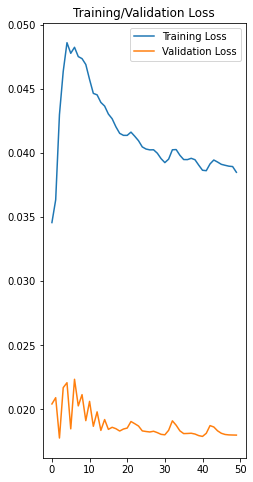

Epoch 1/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0327 - mae: 0.0270 - rmse: 0.0327 - val_loss: 0.0740 - val_mae: 0.0592 - val_rmse: 0.0761
Epoch 2/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0308 - mae: 0.0251 - rmse: 0.0308 - val_loss: 0.0717 - val_mae: 0.0568 - val_rmse: 0.0744
Epoch 3/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0277 - mae: 0.0222 - rmse: 0.0277 - val_loss: 0.0719 - val_mae: 0.0570 - val_rmse: 0.0745
Epoch 4/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0283 - mae: 0.0228 - rmse: 0.0282 - val_loss: 0.0716 - val_mae: 0.0568 - val_rmse: 0.0744
Epoch 5/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0291 - mae: 0.0237 - rmse: 0.0291 - val_loss: 0.0719 - val_mae: 0.0569 - val_rmse: 0.0744

Epoch 00005: val_loss did not improve from 0.01589
Epoch 6/50
95/95 [==============================] - 1s 8ms/step - loss: 0.0301 - mae: 0.0246 - rmse: 0.0300 - val_loss: 0.0719 -

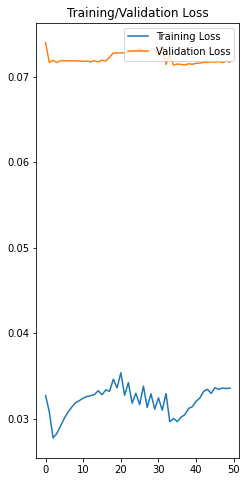

[array([[2476.32  , 2490.6501]], dtype=float32), array([[2479.8076, 2493.032 ]], dtype=float32), array([[2483.4119, 2495.9946]], dtype=float32), array([[2486.9248, 2499.037 ]], dtype=float32), array([[2490.3616, 2502.0576]], dtype=float32), array([[2493.676, 2505.074]], dtype=float32), array([[2496.5542, 2507.8616]], dtype=float32), array([[2499.3638, 2510.6235]], dtype=float32), array([[2502.2708, 2513.4675]], dtype=float32), array([[2505.2634, 2516.3755]], dtype=float32), array([[2508.3289, 2519.339 ]], dtype=float32), array([[2511.4097, 2522.3157]], dtype=float32), array([[2514.5125, 2525.3125]], dtype=float32), array([[2517.6375, 2528.3308]], dtype=float32), array([[2520.786 , 2531.3713]], dtype=float32)]
[2476.32, 2479.8076, 2483.4119, 2486.9248, 2490.3616, 2493.676, 2496.5542, 2499.3638, 2502.2708, 2505.2634, 2508.3289, 2511.4097, 2514.5125, 2517.6375, 2520.786]


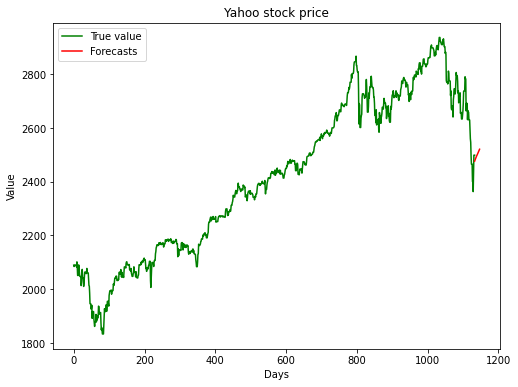

Epoch 1/90
32/32 [==============================] - 3s 24ms/step - loss: 0.3302 - mae: 0.3170 - rmse: 0.3301 - val_loss: 0.0325 - val_mae: 0.0263 - val_rmse: 0.0364
Epoch 2/90
32/32 [==============================] - 0s 8ms/step - loss: 0.1230 - mae: 0.1080 - rmse: 0.1230 - val_loss: 0.0311 - val_mae: 0.0280 - val_rmse: 0.0322
Epoch 3/90
32/32 [==============================] - 0s 10ms/step - loss: 0.0792 - mae: 0.0702 - rmse: 0.0792 - val_loss: 0.0369 - val_mae: 0.0338 - val_rmse: 0.0382
Epoch 4/90
32/32 [==============================] - 0s 8ms/step - loss: 0.0803 - mae: 0.0703 - rmse: 0.0803 - val_loss: 0.0341 - val_mae: 0.0309 - val_rmse: 0.0356
Epoch 5/90
32/32 [==============================] - 0s 9ms/step - loss: 0.0845 - mae: 0.0746 - rmse: 0.0845 - val_loss: 0.0298 - val_mae: 0.0266 - val_rmse: 0.0316

Epoch 00005: val_loss improved from inf to 0.02980, saving model to my_model_5_0.030.h5
Epoch 6/90
32/32 [==============================] - 0s 9ms/step - loss: 0.0870 - mae: 0.0

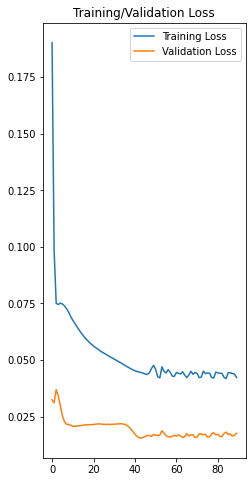

Epoch 1/90
64/64 [==============================] - 1s 16ms/step - loss: 0.0335 - mae: 0.0273 - rmse: 0.0334 - val_loss: 0.0201 - val_mae: 0.0160 - val_rmse: 0.0201
Epoch 2/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0369 - mae: 0.0309 - rmse: 0.0368 - val_loss: 0.0228 - val_mae: 0.0183 - val_rmse: 0.0228
Epoch 3/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0410 - mae: 0.0350 - rmse: 0.0407 - val_loss: 0.0249 - val_mae: 0.0209 - val_rmse: 0.0249
Epoch 4/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0467 - mae: 0.0407 - rmse: 0.0463 - val_loss: 0.0230 - val_mae: 0.0190 - val_rmse: 0.0230
Epoch 5/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0515 - mae: 0.0457 - rmse: 0.0510 - val_loss: 0.0272 - val_mae: 0.0236 - val_rmse: 0.0272

Epoch 00005: val_loss did not improve from 0.01574
Epoch 6/90
64/64 [==============================] - 1s 8ms/step - loss: 0.0528 - mae: 0.0469 - rmse: 0.0524 - val_loss: 0.0222 

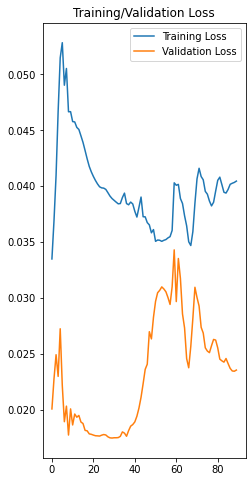

Epoch 1/90
95/95 [==============================] - 1s 9ms/step - loss: 0.0366 - mae: 0.0308 - rmse: 0.0366 - val_loss: 0.0723 - val_mae: 0.0581 - val_rmse: 0.0757
Epoch 2/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0367 - mae: 0.0306 - rmse: 0.0367 - val_loss: 0.0726 - val_mae: 0.0582 - val_rmse: 0.0754
Epoch 3/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0321 - mae: 0.0264 - rmse: 0.0321 - val_loss: 0.0735 - val_mae: 0.0586 - val_rmse: 0.0766
Epoch 4/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0300 - mae: 0.0242 - rmse: 0.0300 - val_loss: 0.0743 - val_mae: 0.0592 - val_rmse: 0.0763
Epoch 5/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0310 - mae: 0.0256 - rmse: 0.0309 - val_loss: 0.0752 - val_mae: 0.0614 - val_rmse: 0.0773

Epoch 00005: val_loss did not improve from 0.01574
Epoch 6/90
95/95 [==============================] - 1s 8ms/step - loss: 0.0356 - mae: 0.0298 - rmse: 0.0355 - val_loss: 0.0720 -

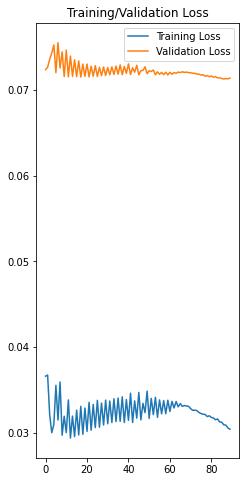

[array([[2477.2295, 2486.661 ]], dtype=float32), array([[2479.7363, 2488.135 ]], dtype=float32), array([[2483.5317, 2491.6333]], dtype=float32), array([[2487.4736, 2495.4788]], dtype=float32), array([[2490.854 , 2498.8103]], dtype=float32), array([[2493.791, 2501.698]], dtype=float32), array([[2496.138, 2503.956]], dtype=float32), array([[2498.3853, 2506.1687]], dtype=float32), array([[2500.7954, 2508.6067]], dtype=float32), array([[2503.3606, 2511.2102]], dtype=float32), array([[2506.0598, 2513.9485]], dtype=float32), array([[2508.7793, 2516.6946]], dtype=float32), array([[2511.5203, 2519.4612]], dtype=float32), array([[2514.294 , 2522.2607]], dtype=float32), array([[2517.112 , 2525.1045]], dtype=float32)]
[2477.2295, 2479.7363, 2483.5317, 2487.4736, 2490.854, 2493.791, 2496.138, 2498.3853, 2500.7954, 2503.3606, 2506.0598, 2508.7793, 2511.5203, 2514.294, 2517.112]


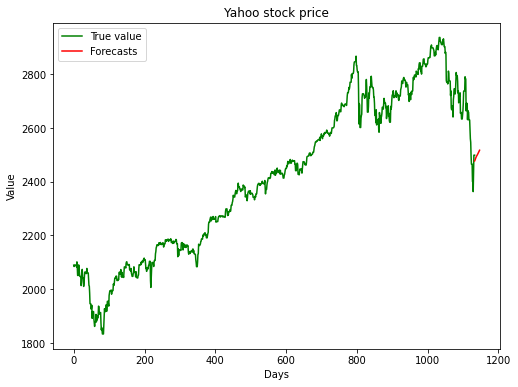

Epoch 1/120
32/32 [==============================] - 2s 24ms/step - loss: 0.2308 - mae: 0.2266 - rmse: 0.2308 - val_loss: 0.0473 - val_mae: 0.0427 - val_rmse: 0.0483
Epoch 2/120
32/32 [==============================] - 0s 8ms/step - loss: 0.0753 - mae: 0.0647 - rmse: 0.0753 - val_loss: 0.0333 - val_mae: 0.0297 - val_rmse: 0.0350
Epoch 3/120
32/32 [==============================] - 0s 10ms/step - loss: 0.0855 - mae: 0.0748 - rmse: 0.0855 - val_loss: 0.0270 - val_mae: 0.0235 - val_rmse: 0.0287
Epoch 4/120
32/32 [==============================] - 0s 9ms/step - loss: 0.0834 - mae: 0.0743 - rmse: 0.0834 - val_loss: 0.0229 - val_mae: 0.0189 - val_rmse: 0.0252
Epoch 5/120
32/32 [==============================] - 0s 9ms/step - loss: 0.0859 - mae: 0.0773 - rmse: 0.0858 - val_loss: 0.0199 - val_mae: 0.0155 - val_rmse: 0.0228

Epoch 00005: val_loss improved from inf to 0.01991, saving model to my_model_5_0.020.h5
Epoch 6/120
32/32 [==============================] - 0s 10ms/step - loss: 0.0874 - m

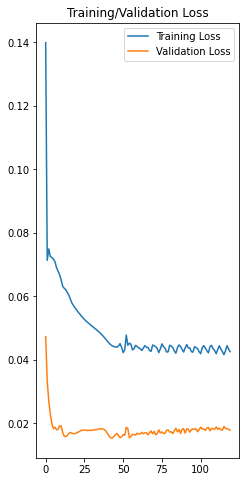

Epoch 1/120
64/64 [==============================] - 1s 16ms/step - loss: 0.0346 - mae: 0.0283 - rmse: 0.0346 - val_loss: 0.0252 - val_mae: 0.0209 - val_rmse: 0.0252
Epoch 2/120
64/64 [==============================] - 1s 8ms/step - loss: 0.0363 - mae: 0.0299 - rmse: 0.0362 - val_loss: 0.0200 - val_mae: 0.0159 - val_rmse: 0.0200
Epoch 3/120
64/64 [==============================] - 1s 8ms/step - loss: 0.0386 - mae: 0.0327 - rmse: 0.0386 - val_loss: 0.0232 - val_mae: 0.0188 - val_rmse: 0.0232
Epoch 4/120
64/64 [==============================] - 1s 9ms/step - loss: 0.0404 - mae: 0.0347 - rmse: 0.0402 - val_loss: 0.0267 - val_mae: 0.0230 - val_rmse: 0.0267
Epoch 5/120
64/64 [==============================] - 1s 8ms/step - loss: 0.0454 - mae: 0.0392 - rmse: 0.0450 - val_loss: 0.0231 - val_mae: 0.0195 - val_rmse: 0.0231

Epoch 00005: val_loss did not improve from 0.01544
Epoch 6/120
64/64 [==============================] - 1s 8ms/step - loss: 0.0548 - mae: 0.0485 - rmse: 0.0543 - val_loss: 0

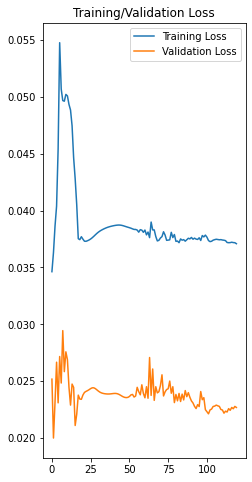

Epoch 1/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0335 - mae: 0.0279 - rmse: 0.0335 - val_loss: 0.0897 - val_mae: 0.0763 - val_rmse: 0.0909
Epoch 2/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0340 - mae: 0.0282 - rmse: 0.0340 - val_loss: 0.0731 - val_mae: 0.0589 - val_rmse: 0.0757
Epoch 3/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0289 - mae: 0.0233 - rmse: 0.0289 - val_loss: 0.0740 - val_mae: 0.0605 - val_rmse: 0.0764
Epoch 4/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0296 - mae: 0.0239 - rmse: 0.0295 - val_loss: 0.0780 - val_mae: 0.0649 - val_rmse: 0.0797
Epoch 5/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0301 - mae: 0.0247 - rmse: 0.0301 - val_loss: 0.0761 - val_mae: 0.0635 - val_rmse: 0.0781

Epoch 00005: val_loss did not improve from 0.01544
Epoch 6/120
95/95 [==============================] - 1s 8ms/step - loss: 0.0346 - mae: 0.0286 - rmse: 0.0345 - val_loss: 0.

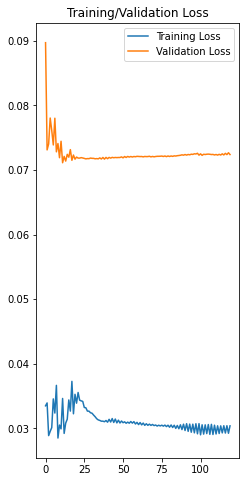

[array([[2470.8374, 2481.1392]], dtype=float32), array([[2471.0037, 2478.8943]], dtype=float32), array([[2472.5596, 2479.7012]], dtype=float32), array([[2474.3877, 2481.2998]], dtype=float32), array([[2475.8347, 2482.7432]], dtype=float32), array([[2476.9766, 2483.9216]], dtype=float32), array([[2477.0227, 2484.2249]], dtype=float32), array([[2477.0244, 2484.2886]], dtype=float32), array([[2477.3162, 2484.531 ]], dtype=float32), array([[2477.7258, 2484.9126]], dtype=float32), array([[2478.244, 2485.41 ]], dtype=float32), array([[2478.6912, 2485.8733]], dtype=float32), array([[2479.1338, 2486.3223]], dtype=float32), array([[2479.5784, 2486.771 ]], dtype=float32), array([[2480.0325, 2487.2285]], dtype=float32)]
[2470.8374, 2471.0037, 2472.5596, 2474.3877, 2475.8347, 2476.9766, 2477.0227, 2477.0244, 2477.3162, 2477.7258, 2478.244, 2478.6912, 2479.1338, 2479.5784, 2480.0325]


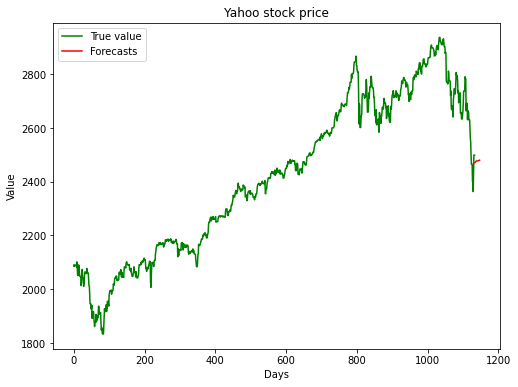

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.05961655359715223, 0.05486623321970304, 0.059503299680848915, 0.04269927761827907, 0.03642246363063653, 0.0428337584870557] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.0446461034193635, 0.03961102239787579, 0.04458255223929882, 0.0446996432604889, 0.03938997076203426, 0.044902406378338734] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.03880322101836403, 0.03373698626955351, 0.03873402820900083, 0.062222003011653815, 0.05759522151357183, 0.06223064171150327] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.04304626346048381, 0.038106485383792056, 0.0429276841899587, 0.03786922867616846, 0.032304273646635316, 0.0381212055320955] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.039298911723825665, 0.034111904739229766, 0.039172343095695526, 0.05077306721359492, 0.04567658236871

In [20]:
print(final_dict)

{1: [0.05961655359715223, 0.05486623321970304, 0.059503299680848915, 0.04269927761827907, 0.03642246363063653, 0.0428337584870557], 2: [0.0446461034193635, 0.03961102239787579, 0.04458255223929882, 0.0446996432604889, 0.03938997076203426, 0.044902406378338734], 3: [0.03880322101836403, 0.03373698626955351, 0.03873402820900083, 0.062222003011653815, 0.05759522151357183, 0.06223064171150327], 4: [0.04304626346048381, 0.038106485383792056, 0.0429276841899587, 0.03786922867616846, 0.032304273646635316, 0.0381212055320955], 5: [0.039298911723825665, 0.034111904739229766, 0.039172343095695526, 0.05077306721359492, 0.04567658236871164, 0.05081322272135704], 6: [0.037231403899689514, 0.03214930632772545, 0.037103998071203625, 0.04634678688210745, 0.041135145735461266, 0.046447457093745474], 7: [0.043681415033837157, 0.037294681730369726, 0.04345848575234413, 0.03619364012653629, 0.02830140132457018, 0.03815131098031998], 8: [0.04152937375560955, 0.03498680234231331, 0.04132827747337244, 0.0383

In [21]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.059617,0.054866,0.059503,0.042699,0.036422,0.042834
2,0.044646,0.039611,0.044583,0.044700,0.039390,0.044902
3,0.038803,0.033737,0.038734,0.062222,0.057595,0.062231
4,0.043046,0.038106,0.042928,0.037869,0.032304,0.038121
5,0.039299,0.034112,0.039172,0.050773,0.045677,0.050813
6,0.037231,0.032149,0.037104,0.046347,0.041135,0.046447
7,0.043681,0.037295,0.043458,0.036194,0.028301,0.038151
8,0.041529,0.034987,0.041328,0.038304,0.030372,0.040322
9,0.039713,0.033403,0.039508,0.038070,0.030010,0.040151


In [22]:
final_df.to_csv(r"resultados.csv",index=True)